# Normalizing Flows

This notebook is intended to investigate the representative power of normalizing flows. Any distribution can be approximated using normalizing flows. Here, we will investigate how well normalizing flows can represent difficult ditributions such as the banana distribution and multimodal distributions with complex correlations. For ease of visualization, only 2d distributions will be investigated here. 


## Forward model

Here we use normalizing flows to approximate the posterior for our forward model

In [1]:
import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize
from torch.utils.data import DataLoader, TensorDataset
import scipy
import time

In [2]:
# define our forward model
def G(L,N,dt,tFinal,Sigma,R_film0, VR, Cv, Qmin, jmin):
    # INPUTS:
    #   L       = domain length (1D)
    #   N       = number of nodes in domain
    #   dt      = time step
    #   Sigma   = model parameter
    #   R_film0 = model parameter; initial film resistance
    #   VR      = model parameter; voltage ramp
    #   Cv      = model parameter
    #   Qmin    = model parameter
    #   jmin    = model parameter
    #
    # OUTPUTS:
    #   Thickness
    #   Resistance
    #   Current
    #   Xi          = indicator of identifiability of Qmin, jmin
    #                 0 -> both identifiable
    #                 1 -> jmin unidentifiable
    #                -1 -> Qmin unidentifiable


    # Initialize necessary variables
    BC_anode = 0 
    R_film = R_film0
    Q = 0
    h = 0
    i = 0
    Resistance = np.zeros((math.floor(tFinal)+1,1))
    Thickness  = np.zeros((math.floor(tFinal)+1,1))
    Current    = np.zeros((math.floor(tFinal)+1,1))

    h_x = L/(N-1)
    e = np.ones((N,1))
    
    # Assemble A(phi) = S
    a = np.ones(N)
    b = np.ones(N-1)
    A = Sigma*(-2*np.diag(a,0)+np.diag(b,-1)+np.diag(b,1))/h_x**2
    A[-1,-2]=0
    A[0,1] = 2*Sigma/h_x**2

    SN_fac = -2*Sigma/h_x**2
    j_fac = Sigma/h_x
    S = np.zeros((N,1))
    depositionStart=False
    t = 0
    chk_tol = dt/10
    while (t<tFinal):
        i += 1
        BC_anode = BC_anode + VR*dt
        S[-1] = SN_fac*BC_anode
        a = -R_film*Sigma
        A[0,0] = SN_fac*(1-h_x/a)
        
        phi = np.linalg.solve(A,S)
        j = j_fac*(phi[1]-phi[0])
        Q = Q + j*dt

        '''
        if (Q>Qmin):
            depositionStart = True
        if depositionStart: # threshold criterion
            h = np.maximum(h + Cv*(j-jmin)*dt, 0) # film thickness
            rho_j = np.maximum(8e6*np.exp(-0.1*j),2e6) # resistivity of film
            R_film = np.maximum(R_film + rho_j*Cv*(j-jmin)*dt, 0) # film resistance
        '''
        if (Q>Qmin) and (j > jmin): # threshold criterion
            h = h + Cv*j*dt # film thickness
            rho_j = np.maximum(8e6*np.exp(-0.1*j),2e6) # resistivity of film
            R_film = R_film + rho_j*Cv*j*dt # film resistance        
        
        t += dt
        if ((t%1)<chk_tol)or(((t%1)-1)>-chk_tol):
            tind = int(np.rint(t))
            Resistance[tind,0] = R_film
            Thickness[tind,0] = h
            Current[tind,0] = j
        
        Xi = 0

    return Thickness, Resistance, Current, Xi

## First, generate the inference data

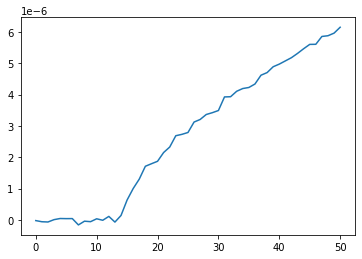

In [3]:
Sigma       = 0.14  # 
Cv          = 1e-7  #
R_film0     = 0.5   # Initial film resistance
VR          = 1     # Voltage Ramp
jmin        = 1     #
Qmin        = 150   #
rho_j       = 5e6   #
L           = 0.0254# Domain length
Nx          = 11    # Number of spatial domain nodes
dt          = 0.01   # Forward model time step
tFinal      = 50   # Forward model final time
sig_thk     = 8e-8  # noise for thickness data

n_samples = 5

Thk, Res, Cur, Xi = G(L, Nx, dt, tFinal, Sigma, R_film0, VR, Cv, Qmin, jmin)

Thk_d = np.zeros((n_samples, np.shape(Thk)[0]))
for i in range(n_samples):
    Thk_d[i,:] = Thk[:,0] + np.random.normal(0, sig_thk, np.shape(Thk[:,0]))


plt.figure(1)
plt.plot(Thk_d[0,:])



### We will perform Gaussian mean-field VI first on the forward model (must be gradient-free)

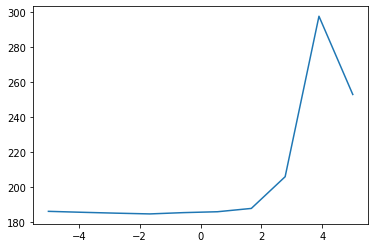

In [4]:
def forwardModel(x):
    Thk, _, _, _ = G(L,Nx,dt,tFinal,Sigma,R_film0,VR,10**(-7.0),x,1.0)
    return Thk

def optim(params, prior, Model, data, C_D, b):
    # params = [mean, logvar] of posterior
    # prior = [mean, logvar] of prior
    # Model = forward model 
    # data
    # b = number of MC samples
    
    d = np.shape(data)[0] # how many data samples we have
    D = 1
    mup = 140#prior[:D]
    logvarp = prior#[D:]
    
    mu = 150#params[:D]
    logvar = params#[D:]
    
    std = np.exp(0.5*logvar)
    eps = np.random.randn(b,D)
    samples = mu + std * eps
    
    G = np.zeros((b,np.shape(data)[1]))
    for i in range(b):
        G_temp = Model(samples[i,:])
        G[i,:] = G_temp[:,0]
        
    lr = np.sum(0.5*((np.tile(data, (b,1,1))-np.transpose(np.tile(G, (d,1,1)), (1,0,2)))**2 / np.tile(C_D, (b, d, 1))), (1,2))# /max_output
    #print(np.shape(np.tile(data,(b,1,1))))
    #print(np.shape(np.transpose(np.tile(G,(d,1,1)), (1,0,2))))
    lr = np.mean(lr)
    #print(lr)
    #print(0.5*np.sum((mu**2 - 2*mu*mup + np.exp(logvar))/np.exp(logvarp)))
    return 0.5*np.sum((mu**2 - 2*mu*mup + np.exp(logvar))/np.exp(logvarp)) - np.sum(0.5*logvar) + lr
    
prior = np.array([np.log(25**2)])#140, np.log(25**2)])#np.array([7.0, 140, 1, np.log(1**2), np.log(25**2), np.log(0.25**2)])
post0 = np.array([np.log(1e1**2)])#145, np.log(1e-2**2)])#np.array([7.0, 140, 1, np.log(1e-2**2), np.log(1e-1**2), np.log(1e-2**2)])

#initial_simplex = np.random.randn(7,6)*2 + prior
C_D = np.var(Thk_d, axis = 0)

MC = 10 # samples for MC estimate of expectation
#opt = scipy.optimize.minimize(optim, post0, args=(prior, forwardModel, Thk_d, C_D, MC), method='Nelder-Mead', \
                              #options = {'disp':True})

#print(opt)

n = 10
v1 = np.linspace(-5,5,n)
lv = np.zeros(n)
for i in range(n):
    x = 0
    lv[i] = optim(np.array([v1[i]]), prior, forwardModel, Thk_d, C_D, MC)

plt.figure(1)
plt.plot(v1,lv)

### Compute the true posterior

Text(0.5, 0, '$-\\log C_v$')

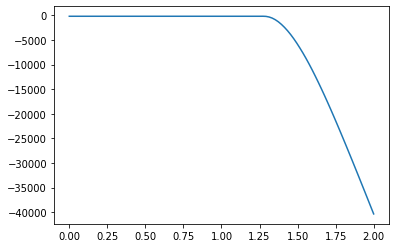

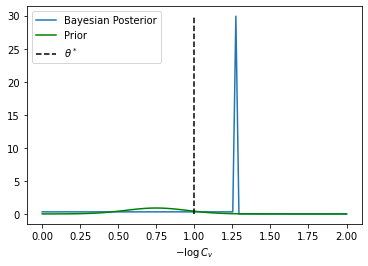

In [6]:
def forwardModel(x):
    Thk, _, _, _ = G(L,Nx,dt,tFinal,Sigma,R_film0,VR,10**(-7),150.0,x)
    return Thk

def post(params, prior, Model, data, C_D):
    # params = [mean, logvar] of posterior
    # prior = [mean, logvar] of prior
    # Model = forward model 
    # data
    # b = number of MC samples
    
    b=1
    d = np.shape(data)[0] # how many data samples we have
    D = 1
    mup = prior[:D]
    logvarp = prior[D:]
    
    samples = params
    
    Gt = np.zeros((1,d))
    G_temp = Model(samples)
    Gt = G_temp[:,0]
    
        
    lr = -np.sum(0.5*((np.tile(data, (b,1,1))-np.transpose(np.tile(Gt, (d,1,1)), (1,0,2)))**2 / np.tile(C_D, (b, d, 1))), (1,2)) \
            - 0.5*np.sum(C_D)# /max_output

    lr = np.mean(lr)
    if params<0:
        prior = 0
    elif params>2:
        prior = 0
    else:
        prior = 1
    return lr + prior#0.5*((mup-samples)**2/np.exp(logvarp) + logvarp)  
    
prior = np.array([0.75, np.log(0.2**2)])

C_D = np.var(Thk_d, axis = 0)

n = 100
v1 = np.linspace(0,2,n)
lv = np.zeros(n)
for i in range(n):
    x = 0
    lv[i] = post(v1[i], prior, forwardModel, Thk_d, C_D)

post = np.exp((lv+200))

Z = sum(post)*(v1[1]-v1[0])
post = post/Z

pv0 = 1/np.sqrt(2*np.pi*np.exp(0.5*prior[1]))*np.exp(-0.5*((prior[0]-v1)**2/np.exp(prior[1])))

plt.figure(1)
plt.plot(v1,lv)

plt.figure(2)
plt.plot(v1,post, label='Bayesian Posterior')
plt.plot(v1, pv0, 'g', label='Prior')
plt.plot([jmin, jmin], [0, np.max(post)], 'k--', label=r'$\theta^*$')
plt.legend()
plt.xlabel(r'$-\log C_v$')

In [7]:
A = np.array([[1, 2],[3, 4], [5, 6]])
C = np.array([1,2,3,4])
print(np.shape(np.tile(C, (2,2,1))))
print(A)
print(np.shape(np.tile(A, (1,1,2))))

(2, 2, 4)
[[1 2]
 [3 4]
 [5 6]]
(1, 3, 4)


## Now Generate the data to train a surrogate model

Input data shape:  torch.Size([51, 200, 3])
Output data shape:  torch.Size([51, 200, 1])
7.399234915039546e-05


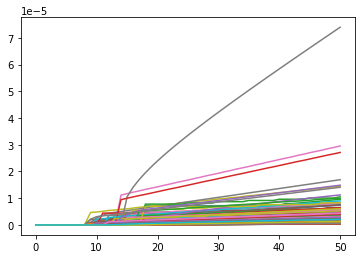

In [8]:

n_d_sur = 200 # number of data samples for surrogate model


samps = np.random.uniform(0, 1, (n_d_sur, 3))
scales = np.ones((1, 3))
scales[0,0] = 5 # Cv
scales[0,1] = 200 # Qmin
scales[0,2] = 5 # jmin
offset = np.zeros((1, 3))
offset[0,0] = 4.5 # Cv
offset[0,1] = 50 # Qmin
samps = samps * scales + offset

thk_data_sur = np.zeros((n_d_sur, np.shape(Thk)[0]))
plt.figure(2)
for i in range(n_d_sur):
    temp, _, _, _ = G(L, Nx, dt, tFinal, Sigma, R_film0, VR, 10**(-samps[i,0]), samps[i,1], samps[i,2])
    thk_data_sur[i,:] = temp[:,0]
    plt.plot(temp)
thk_data_sur = np.reshape(thk_data_sur, (tFinal+1, n_d_sur, 1)) # reshape for training
#plt.ylim([0, 5e-6])

inp_data_sur = samps

# regularize the input data
inp_data_sur = (inp_data_sur - offset) / scales

inp_data_sur = np.tile(inp_data_sur, (tFinal+1, 1, 1)) # reshape for training

# scale the output data
max_output = np.max(thk_data_sur)
thk_data_sur = thk_data_sur / max_output



inp_data_sur = torch.from_numpy(inp_data_sur).float()
thk_data_sur = torch.from_numpy(thk_data_sur).float()
print("Input data shape: ", np.shape(inp_data_sur))
print("Output data shape: ", np.shape(thk_data_sur))
print(max_output)

# Include the below lines for data processing if using FNN surrogate
inp_data_sur = inp_data_sur[0,:,:]
thk_data_sur = np.reshape(thk_data_sur, (n_d_sur, tFinal+1))

### Surrogate Model
We first want to create a surrogate model using LSTMs for time series prediction. The will greatly aid in the speed of inference and prediction.

In [9]:
# create the LSTM model
class SurrogateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.lstm = nn.Sequential()
        self.lstm.add_module('lstm1', nn.LSTM(input_size, hidden_size, num_layers))
        self.ff1 = nn.Linear(hidden_size, 128)
        self.ff2 = nn.Linear(20, 128)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        #h0 = torch.autograd.Variable(torch.zeros((self.num_layers, x.size(1), self.hidden_size)))
        #c0 = torch.autograd.Variable(torch.zeros((self.num_layers, x.size(1), self.hidden_size)))
        output, (hn, cn) = self.lstm(x)#, (h0, c0))
        output = output[:, :, 0].unsqueeze(2)
        '''
        print(np.shape(output))
        print(np.shape(output.reshape(x.size(1),  -1)))
        
        output = self.ff1(output.reshape(x.size(1), -1))
        output = self.act(output)
        output = self.ff2(output)
        '''
        return output
    
class SurrogateFNN(nn.Module):
    def __init__(self, input_size, output_size, n_layers, n_nodes, act = nn.ReLU()):
        super().__init__()
        self.input_size = input_size
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.act = act
        
        self.FNN = nn.Sequential()
        self.FNN.add_module('fnn0', nn.Linear(input_size, n_nodes))
        self.FNN.add_module('act0', act)
        for i in range(n_layers - 1):
            self.FNN.add_module('fnn%d'% (i+1), nn.Linear(n_nodes, n_nodes))
            self.FNN.add_module('act%d'% (i+1), act)
            
        self.FNN.add_module('fnn_final', nn.Linear(n_nodes, output_size))
        self.FNN.add_module('relu_final', nn.Sigmoid())
        
    def forward(self, x):
        return self.FNN(x)
                                              
                                            

In [25]:
# now define parameters and train
epochs = 120000

# ------- For LSTM Surrogate -------------------
#input_size = 3
#hidden_size = 5
#num_layers = 2

#Surrogate = SurrogateLSTM(input_size, hidden_size, num_layers)
# ----------------------------------------------

# -------------------- For FNN Surrogate ------------------
n_layers = 5
n_nodes = 64
act = nn.SiLU()
#Surrogate = SurrogateFNN(3, tFinal+1, n_layers, n_nodes, act=act)
# ---------------------------------------------------------

#optimizer1 = torch.optim.Adam(Surrogate.parameters(), lr = 1e-3)
optimizer1.param_groups[0]['lr'] = 1e-4

loss_v = np.zeros(epochs)
for epoch in range(epochs):
    Surrogate.zero_grad()
    outputs = Surrogate.forward(inp_data_sur)
    
    #print(np.shape(outputs))
    #print(np.shape(thk_data_sur))
    
    loss = torch.mean((outputs - thk_data_sur)**2)
    loss.backward()
    optimizer1.step()
    
    loss_v[epoch] = loss.detach().numpy()
    if epoch % (epochs//10) == 0:
        print("Epoch: ", epoch, " Loss: ", loss)
    

Epoch:  0  Loss:  tensor(7.2202e-09, grad_fn=<MeanBackward0>)
Epoch:  12000  Loss:  tensor(6.8593e-09, grad_fn=<MeanBackward0>)
Epoch:  24000  Loss:  tensor(6.6321e-09, grad_fn=<MeanBackward0>)
Epoch:  36000  Loss:  tensor(6.4077e-09, grad_fn=<MeanBackward0>)
Epoch:  48000  Loss:  tensor(6.2153e-09, grad_fn=<MeanBackward0>)
Epoch:  60000  Loss:  tensor(6.0389e-09, grad_fn=<MeanBackward0>)
Epoch:  72000  Loss:  tensor(5.8745e-09, grad_fn=<MeanBackward0>)
Epoch:  84000  Loss:  tensor(8.7089e-09, grad_fn=<MeanBackward0>)
Epoch:  96000  Loss:  tensor(5.7707e-09, grad_fn=<MeanBackward0>)
Epoch:  108000  Loss:  tensor(5.5026e-09, grad_fn=<MeanBackward0>)


In [27]:
# save or load the surrogate model

torch.save(Surrogate.state_dict(), 'surrogate.hdf5')


[123]
tensor([[0.4464, 0.5627, 0.6327],
        [0.7086, 0.9686, 0.3240],
        [0.1860, 0.0451, 0.8672],
        [0.3190, 0.9193, 0.7952],
        [0.1355, 0.0979, 0.3630]])
Final Loss:  5.454095841628259e-09


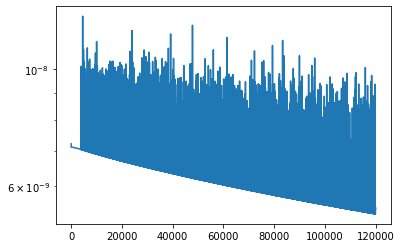

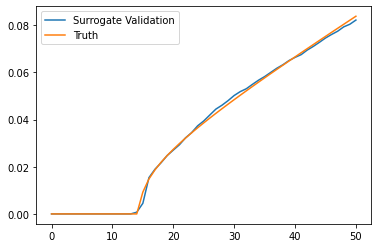

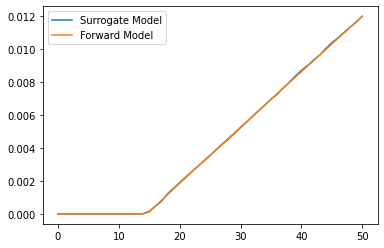

In [26]:
# plot training loss
plt.figure(2)
plt.semilogy(loss_v)

# post process prediction results
valid_input = torch.rand((1, 3))
valid_input[:, 0] = (7.0 - offset[0,0])/scales[0,0]
valid_input[:, 1] = (150.0 - offset[0,1])/scales[0,1]
valid_input[:, 2] = (1.0 - offset[0,2])/scales[0,2]
valid_output = Surrogate(valid_input)
plt.figure(5)
plt.plot(valid_output[0,:].detach().numpy(), label='Surrogate Validation')
plt.plot(Thk[:,0] / max_output, label='Truth')
plt.legend()

post_output = Surrogate(inp_data_sur)#post_input)

plt.figure(1)
ind = np.random.randint(0, n_d_sur, 1)
print(ind)
plt.plot(post_output[ind[0],:].detach().numpy(), label="Surrogate Model")
plt.plot(thk_data_sur[ind[0],:], label="Forward Model")
plt.legend()

print(inp_data_sur[:5, :])
print("Final Loss: ", loss_v[-1])

#### Now we create the normalizing flow classes and train the model using data generated from our forward model

In [28]:
# we first create the base inference network

class encoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(encoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))

# now the decoding network (mirrors the encoder)

class decoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(decoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))
    

# now define the flow layers

class PlanarFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        act = torch.tanh
        self.D = D
        
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.act = act
        self.act_deriv = lambda x: 1 - torch.tanh(x)**2
        
        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)
        
        #self.a = nn.Parameter(0*torch.ones(1))
        #nn.init.normal_(self.a)
        
    def forward(self, z):
        
        dot = torch.sum(self.w*self.u)
        u = self.u + (torch.log(1+torch.exp(dot))-1-dot)*self.w/torch.sum(self.w**2)
        lin = (z @ self.w + self.b).unsqueeze(1)
        f = z + u * self.act(lin)
        phi = self.act_deriv(lin) * self.w
        log_det = torch.log(torch.abs(1+phi@u))
        
        #f = z + self.a
        #log_det = 1
        
        return f, log_det

class RadialFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        
        self.D = D
        self.z0 = nn.Parameter(torch.empty(D))
        self.beta = nn.Parameter(torch.empty(1))
        self.alpha = nn.Parameter(torch.empty(1))
        
        nn.init.normal_(self.z0)
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)
        
    def forward(self, z):
        beta = torch.log(1+torch.exp(self.beta)) - torch.abs(self.alpha) # to ensure layer is invertible
        r = torch.linalg.vector_norm(z - self.z0, dim = 1)

        h = beta / (torch.abs(self.alpha) + r)
        h_prime = -beta * r / (torch.abs(self.alpha)+r) ** 2
        f = z + h.unsqueeze(1)*(z-self.z0)

        log_det = (self.D-1) * torch.log(1+h) \
                  + torch.log(1+h+h_prime)       
        return f, log_det 
    
    
class G_torch(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z):
        # Define all of the parameters
        Sigma       = 0.14  # 
        #Cv          = 1e-7  #
        R_film0     = 0.5   # Initial film resistance
        VR          = 1     # Voltage Ramp
        #jmin        = 1     #
        #Qmin        = 150   #
        rho_j       = 5e6   #
        L           = 0.0254# Domain length
        N          = 11    # Number of spatial domain nodes
        dt          = 0.1   # Forward model time step
        tFinal      = 50   # Forward model final time
        
        
        batch_size = np.shape(z)[0]
        #z = torch.exp(z)
        Cv = torch.pow(10.0, -z)#[:,0])
        #Qmin = z[:,1]
        #jmin = z[:,2]
        #Cv = 1e-7
        Qmin = 150
        jmin = 1.0
        
        Thk_d = torch.zeros((batch_size, tFinal+1))
        
        h_x = L/(N-1)
        SN_fac = -2*Sigma/h_x**2
        j_fac = Sigma/h_x
        e = torch.ones((N,1))
        al = torch.ones(N)
        b = torch.ones(N-1)
        
        for k in range(batch_size):
            
            # Initialize necessary variables
            BC_anode = 0 
            R_film = R_film0
            Q = 0
            h = 0 
            i = 0
            Resistance = torch.zeros((math.floor(tFinal)+1,1))
            Thickness  = torch.zeros((math.floor(tFinal)+1,1))
            Current    = torch.zeros((math.floor(tFinal)+1,1))

            
            # Assemble A(phi) = S

            A = Sigma*(-2*torch.diag(al,0)+torch.diag(b,-1)+torch.diag(b,1))/h_x**2
            A[-1,-2]=0
            A[0,1] = 2*Sigma/h_x**2
            A[0,0] = 0
            A = A.repeat(1002, 1, 1)

            R_film = R_film0*torch.ones((1000 + 2,))
            h = torch.zeros((1000 + 2, ))
            rho_j = torch.zeros((1002, ))
            j = torch.zeros((1002, ))
            Q = torch.zeros((1002, ))
            phi = torch.zeros((1000 + 2, N))
            
            S = torch.zeros((1000 + 2, N))
            Si = S + 0.
            depoStart=False
            t = 0
            chk_tol = dt/10
            while (t<tFinal):
                i = i + 1
                BC_anode = BC_anode + VR*dt
                S[i-1,-1] = SN_fac*BC_anode
                a = -R_film[i-1]*Sigma
                A[i,0,0] = SN_fac*(1-h_x/a)
                #U, s, Vh = torch.linalg.svd(A[:,:,i])
                #Ai = torch.transpose(Vh,0,1)@torch.diag(1/s)@torch.transpose(U,0,1)
                phi[i-1,:] = torch.linalg.solve(A[i,:,:], S[i-1,:])#torch.matmul(Ai, S[i-1,:])
                j[i] = j_fac*(phi[i-1,1]-phi[i-1,0])
                Q[i] = Q[i-1] + j[i]*dt

                if (Q[i]>Qmin):
                    depoStart = True
                if depoStart: # threshold criterion
                    h[i] = torch.maximum(h[i-1] + Cv[k]*(j[i]-jmin)*dt, torch.zeros(1)) # film thickness
                    rho_j[i] = torch.maximum(8e6*torch.exp(-0.1*j[i]),2e6*torch.ones(1)) # resistivity of film
                    R_film[i] = torch.maximum(R_film[i-1] + rho_j[i]*(j[i]-jmin)*Cv[k]*dt,torch.zeros(1)) # film resistance
                else:
                    R_film[i] = R_film[i-1]
                    h[i] = h[i-1]
                    
                t = t + dt
                if ((t%1)<chk_tol)or(((t%1)-1)>-chk_tol):
                    tind = int(np.rint(t))
                    Resistance[tind,0] = R_film[i]
                    Thickness[tind,0] = h[i]
                    Current[tind,0] = j[i]
        
            Xi = 0
            
        
            Thk_d[k,:] = Thickness[:,0]
            
        return Thk_d

        
        
        
        

In [59]:
# now we can define our model

class NormalizingFlowVI(nn.Module):
    def __init__(self, layers, nodes, flow_layers, act=nn.ReLU()):
        super().__init__()
        
        self.encoder_mean = encoder(layers, nodes, act)
        self.encoder_logvar = encoder(layers, nodes, act)
        self.decoder_mean = TrueDecoder() # decoder(layers, nodes, act)
        self.decoder_logvar = nn.Parameter(torch.empty(1))
        
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            self.flow.add_module('flow%d'%(i+1), PlanarFlow(1))
    
    def forward(self, x):

        batch_size = x.shape[0]
        zmu, zlogvar = self.encoder_mean(x), self.encoder_logvar(x)
        sigma = torch.exp(0.5*zlogvar)
        z = self._reparameterize(zmu, zlogvar)
        z0 = z.clone()
        
        log_prob_z0 = torch.sum( \
                        -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            zlogvar - 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        
        log_det = torch.zeros((batch_size,))
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
         
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2*math.pi)) + z**2), axis = 1)
        
        xmu = self.decoder_mean(z)
        
        log_px_zk = torch.sum(self.gaussian_log_prob(x, xmu, self.decoder_logvar), 1)
        
        return z0, zmu, zlogvar, z, xmu, self.decoder_logvar, \
               log_prob_z0, log_det, log_prob_zk, log_px_zk 
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))
    
class Flow(nn.Module):
    def __init__(self, D, flow_layers, act=nn.ReLU()):
        super().__init__()
        self.D = D
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            #if np.mod(i, 2)==0:
            self.flow.add_module('flow%d'%(i+1), PlanarFlow(D))
            #else:
            #self.flow.add_module('flow%d'%(i+1), RadialFlow(D))
            
        self.mu0 = torch.ones((1,D)) # nn.Parameter(torch.ones((D,))*0.5)
        self.mu0[0,0] = 7.5
        self.mu0[0,1] = 170
        self.mu0[0,2] = 0.5
        self.logvar0 = torch.ones((1,D)) #nn.Parameter(torch.ones((D,))*np.log(1**2))
        self.logvar0[0,0] = np.log(0.1**2)
        self.logvar0[0,1] = np.log(10**2)
        self.logvar0[0,2] = np.log(0.1**2)

    
    def forward(self, n, mu_pzk, var_pzk):#zmu, zlogvar, mu_pzk, var_pzk):
        batch_size = n#zmu.shape[0]
        sigma = torch.exp(0.5*self.logvar0)#torch.exp(0.5*zlogvar)
        zlogvar = torch.ones((n, self.D))*self.logvar0
        zmu = torch.ones((n, self.D))*self.mu0
 
        z = self._reparameterize(zmu, zlogvar)
        
        z0 = z.clone()
        
        log_prob_z0 = torch.sum(- 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        

        log_det = torch.zeros((batch_size,))
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
        #print(z) 
        log_prob_zk = torch.sum(-0.5 * ((z-mu_pzk)**2/var_pzk), axis = 1) # prior z_k
        #print(torch.mean(log_prob_z0))
        #print(torch.mean(log_det))
        #print('zk', (z))#-mu_pzk)**2)
        return z0, zmu, zlogvar, z, \
               log_prob_z0, log_det, log_prob_zk
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))
    
    def comp_prob(self, z, n, ind):
        # takes input n as batch size and ind as the index to compute probability on
        
        sigma = torch.exp(0.5*self.logvar0)
        zmu = torch.ones((n, self.D))*self.mu0
        
        log_prob_z0 = torch.sum(- 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        

        log_det = torch.zeros((n,))
        i = 0
        for layer in self.flow:
            if i==(len(self.flow)-1):
                
                
                # compute the probability of only the ind variable (planar flows)
                dot = torch.sum(layer.w*layer.u)
                u = layer.u + (torch.log(1+torch.exp(dot))-1-dot)*layer.w/torch.sum(layer.w**2)
                lin = (z @ layer.w + layer.b).unsqueeze(1)
                ld = 1 + u[ind] * layer.act_deriv(lin) * layer.w[ind]  
                ld = ld[:,0]  
                log_det += torch.log(torch.abs(ld))
                
                z, _ = layer(z)
                zk = z[:,ind]
            else:
                z, ld = layer(z)
                log_det += ld
                
            i += 1
        
        # return the probability
        return zk, log_prob_z0 - log_det
        

Epoch:  0 Loss:  199335.2544709767
Epoch:  500 Loss:  32018.875296438713
Epoch:  1000 Loss:  31940.832748143748
Epoch:  1500 Loss:  46940.37058871254
Epoch:  2000 Loss:  33468.546383132976
Epoch:  2500 Loss:  157862.58747570697
Epoch:  3000 Loss:  32943.30794871918
Epoch:  3500 Loss:  32605.072150564578
Epoch:  4000 Loss:  36062.68507671574
Epoch:  4500 Loss:  28825.538292903842
Epoch:  5000 Loss:  31237.05599120527
Epoch:  5500 Loss:  29091.33921388989
Epoch:  6000 Loss:  29452.098587790504
Epoch:  6500 Loss:  31050.542076090893
Epoch:  7000 Loss:  32103.407799991382
Epoch:  7500 Loss:  30664.460016163917
Epoch:  8000 Loss:  44844.0898900625
Epoch:  8500 Loss:  31822.185262959916
Epoch:  9000 Loss:  36046.178238999295
Epoch:  9500 Loss:  25870.926503954357
Ellapsed time:  32.829023122787476


Text(0, 0.5, 'Loss')

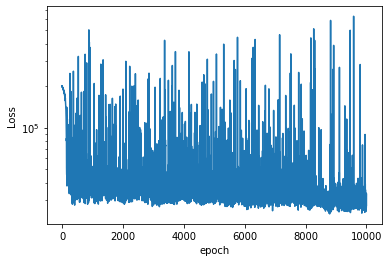

In [60]:
# now load the data and train the model

# First, we define some parameters and priors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

flow_layers = 5
D = 3

# Covariance 'matrix' of the data
C_D = np.var(Thk_d / max_output, axis = 0)
C_D = torch.from_numpy(C_D)

# initial distribution parameters (before to the flow)
#zmu = .75
#zlogvar = 2*np.log(.1)

# prior distribution at the end of the flow
mu_pzk = torch.Tensor([[7.5, 170, 1.]])
var_pzk = torch.Tensor([[1**2, 30**2, 0.5**2]])


d = n_samples # number of data samples
b = 10 # number of samples to approximate expectation
epochs = 5000


# --------------------------------------------------------------------

ForwardModel =  Surrogate #G_torch() #
ForwardModel.to(device)

# process the data
dataset = TensorDataset(torch.tensor(Thk_d).float(), torch.tensor(Thk_d).float())
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
thk_d = torch.tensor(Thk_d).float()
thk_d.to(device)

# initialize the model and optimizer
NF = Flow(D, flow_layers)
NF.to(device)
optimizer = torch.optim.Adam(NF.parameters(), lr=1e-3)

# initialize loss list
t0 = time.time()
loss_v = np.zeros((epochs,))
NF.train()

# train
torch.autograd.set_detect_anomaly(False)

R = 1e0 # change the ratio of losses. Greater R increases entropy of variational posterior
B = 1 # greater B emphasizes reconstruction loss
S = 1

for epoch in range(epochs):
    #for n, (_, thk_d) in enumerate(data_loader):
        
    NF.zero_grad()
    #zMu = zmu*torch.ones((b,D), device = device)
    #zLV = zlogvar*torch.ones((b,D), device = device)
    _,_,_,z, lpz0, ld, lpzk = NF.forward(b, mu_pzk, var_pzk)#zMu, zLV, mu_pzk, var_pzk) 
    #print(np.shape(z))
    inp = torch.zeros((b, 3))
    #z[z<=0] = 1e1*z[z<=0]
    #z[z>=5] = 1e1*z[z>=5]
    # we need to regularize the input to the surrogate
    inp[:,0] = (z[:,0] - offset[0,0])/scales[0,0]
    inp[:,1] = (z[:,1] - offset[0,1])/scales[0,1]
    inp[:,2] = (z[:,2] - offset[0,2])/scales[0,2]
    thk_out = ForwardModel(inp)
    #
    #print('thk_out: ', np.shape(thk_out))
    #print('thk_d  : ', np.shape(thk_d))
    #print('Cd     : ', np.shape(C_D))
    #print('diff: ', np.shape((thk_out-thk_d)/C_D))
    #
    #z = z[:,0]
    
    lr = torch.sum(-0.5*((torch.tile(thk_out, (d,1,1))-torch.tile(thk_d/max_output, (b,1,1)).swapaxes(0,1))**2 / torch.tile(C_D, (d, b, 1))), (0,2))# /max_output
    L = -B*torch.mean(lr) - S*torch.mean(lpzk) + R*torch.mean(lpz0 - ld)
    loss = torch.mean(L)# + torch.exp(1e6*(-torch.min(z)-0)) + torch.exp(1e6*(torch.max(z)-5)) 
    #print(np.shape(lpz0-lpzk-ld-lr))
    
    if torch.isnan(loss):
        print("Loss is nan!")
        print("current z: ", z)
        print("mu0: ", NF.mu0)
        print("var0: ", NF.logvar0)
        break
        
    loss.backward()

    optimizer.step()
    
    loss_v[epoch] = loss.cpu().detach().numpy()
        
    # print out training progress
    if np.mod(epoch, epochs//20)==0:
        #
        #print('Lpz0: ', torch.mean(lpz0))
        #print('Log det: ', torch.mean(ld))
        #print('Rec loss: ', torch.mean(lr))
        #print('lpzk: ', torch.mean(lpzk))
        #
        print('Epoch: ', epoch, 'Loss: ', loss.cpu().detach().numpy())
        #print('lpz0: ', lpz0)
        #print('ld: ', ld)
        #print('lpzk: ', lpzk)
        #print('lr: ', lr)
        #print('p_log_post: ', p_log_post)

t_end = time.time()

print("Ellapsed time: ", t_end-t0)

# plot the loss
plt.figure(2)
#plt.plot(loss_v)
plt.semilogy(loss_v)
#plt.plot([0,epochs],[0,0],'k--')
plt.xlabel('epoch')
plt.ylabel('Loss')


### We want to visualize the log likelihood with respect to changes in the parameters

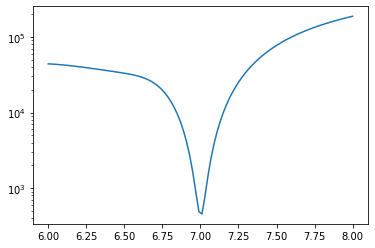

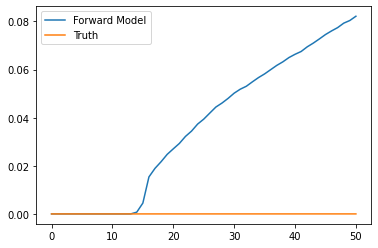

In [61]:
n_vis = 100
b = 1
p_v = torch.linspace(6, 8, n_vis)
l_vis = torch.zeros((n_vis,))
ForwardModel = Surrogate#G_torch() #
#ForwardModel.to(device)
for i in range(len(p_v)):
        inp = torch.zeros((b, 3))
        
        # we need to regularize the input to the surrogate
        inp[:,0] = (p_v[i] - offset[0,0])/scales[0,0]
        inp[:,1] = (150.0 - offset[0,1])/scales[0,1]
        inp[:,2] = (1.0 - offset[0,2])/scales[0,2]
        thk_out = ForwardModel(inp)
        #print('thk_out: ', np.shape(thk_out))
        #print('thk_d:   ', np.shape(thk_d))
        lr = torch.sum(-0.5*((torch.tile(thk_out, (d,1,1))-torch.tile(thk_d/max_output, (b,1,1)).swapaxes(0,1))**2 \
                             /torch.tile(C_D, (d, b, 1))), (0,2)) #  /max_output
        l_vis[i] = torch.mean(-lr)
        
plt.figure(1)
plt.semilogy(p_v.detach().numpy(), l_vis.detach().numpy())

inp = torch.zeros((1, 3))
inp[:,0] = (7.0 - offset[0,0])/scales[0,0]
inp[:,1] = (150.0 - offset[0,1])/scales[0,1]
inp[:,2] = (1.0 - offset[0,2])/scales[0,2]
thk_out = ForwardModel(inp)
plt.figure(2)
plt.plot(thk_out[0,:].detach().numpy(), label='Forward Model')
plt.plot(Thk[:,0], label='Truth')# / max_output, label='Truth')
plt.legend()

max L_recon:  tensor(-17528.2715, dtype=torch.float64, grad_fn=<MaxBackward1>)
KL:  27560.03175998352
Posterior Mean (samples):  tensor([  4.5317, 177.6395,   4.7995], grad_fn=<MeanBackward1>)
Posterior Std  (samples):  tensor([ 0.1011, 10.1454,  0.0998], grad_fn=<SqrtBackward0>)


Text(0.5, 1.0, 'Histogram of Posterior Samples')

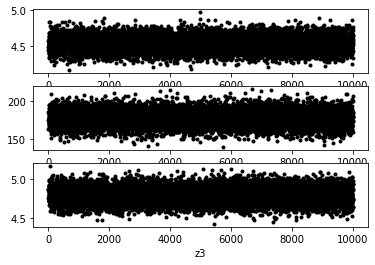

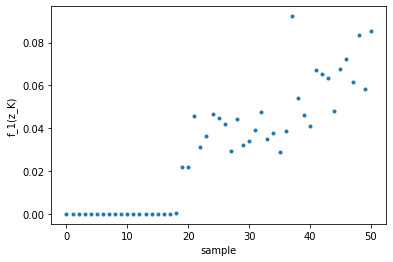

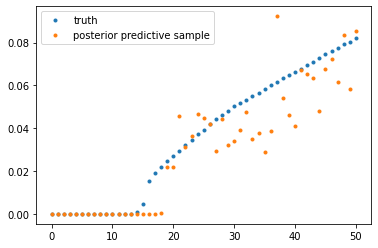

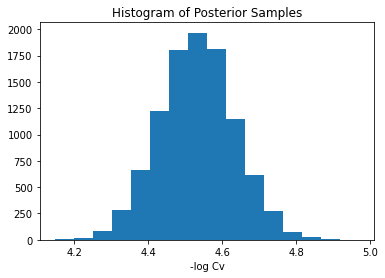

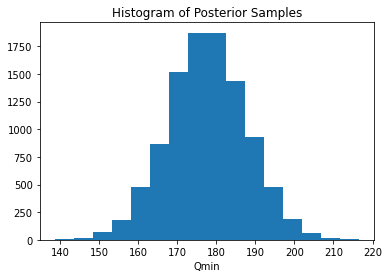

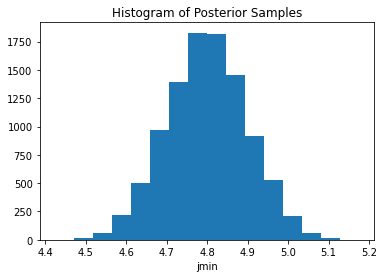

In [62]:
M = 10000
#zMu = NF.mu0*torch.ones((M,D))
#zLV = NF.logvar0*torch.ones((M,D))
_,_,_,z,_,_,_ = NF.forward(M, mu_pzk, var_pzk)#zMu, zLV, mu_pzk, var_pzk)
inp = torch.zeros((M, 3))
inp[:,0] = (z[:,0] - offset[0,0])/scales[0,0]
inp[:,1] = (z[:,1] - offset[0,1])/scales[0,1]
inp[:,2] = (z[:,2] - offset[0,2])/scales[0,2]
y_out = ForwardModel(inp)
b1 = 1
L_recon_sample = torch.sum(-0.5*((torch.tile(y_out, (d,b1,1))-torch.tile(thk_d/max_output, (b1,1,1)).swapaxes(0,1))**2 / torch.tile(C_D, (d, b1, 1))), (0,2))# /max_output
print('max L_recon: ', torch.max(L_recon_sample))

y_out = y_out.detach().numpy()
plt.figure(10)
for i in range(D):
    plt.subplot(D, 1, i+1)
    plt.plot((z[:,i].detach().numpy()), 'k.')
    plt.xlabel('z%d'%(i+1))

plt.figure(1)
plt.plot(y_out[0,:] ,'.')
plt.xlabel('sample')
plt.ylabel('f_1(z_K)')


print("KL: ", loss_v[-1])
#print("Learned Model: ", NF)

z_true = torch.ones((1,3))
z_true[0,0] = (7)
z_true[0,1] = (150)
z_true[0,2] = (1)
z_true = torch.ones((1, 1))*(1.0)
inp = torch.zeros((1, 3))
inp[:,0] = (7.0 - offset[0,0])/scales[0,0]
inp[:,1] = (150.0 - offset[0,1])/scales[0,1]
inp[:,2] = (1.0 - offset[0,2])/scales[0,2]
y_true = ForwardModel(inp)
b = 1
L_true = torch.sum(-0.5*((torch.tile(y_true, (d,b,1))-torch.tile(thk_d/max_output, (b,1,1)).swapaxes(0,1))**2 / torch.tile(C_D, (d, b, 1))), (0,2))# /max_output
#print('L_true: ', L_true)
plt.figure(20)
plt.plot(y_true[0,:].detach().numpy(), '.', label='truth')
plt.plot(y_out[0,:] ,'.', label='posterior predictive sample')
plt.legend()

print('Posterior Mean (samples): ', torch.mean(z, dim=0))
print('Posterior Std  (samples): ', torch.sqrt(torch.var(z, dim=0)))

plt.figure(43)
plt.hist(z[:,0].detach().numpy(), bins=16)
plt.xlabel('-log Cv')
plt.title('Histogram of Posterior Samples')

plt.figure(44)
plt.hist(z[:,1].detach().numpy(), bins=16)
plt.xlabel('Qmin')
plt.title('Histogram of Posterior Samples')

plt.figure(45)
plt.hist(z[:,2].detach().numpy(), bins=16)
plt.xlabel('jmin')
plt.title('Histogram of Posterior Samples')


#print('Recon Loss Sample: ', L_recon_sample)
#print('True Loss: ', L_true)

torch.Size([1000, 1])


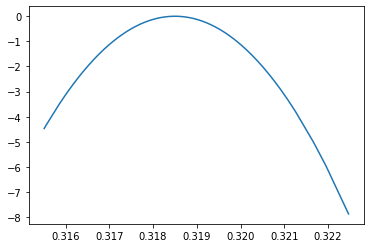

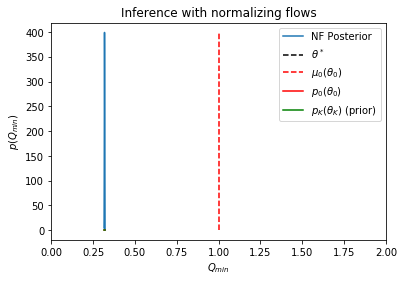

In [88]:
n_s = 1000
ind = 2
z_eval = np.zeros((n_s, D))

z_eval[:,0] = np.random.normal(NF.mu0[0,0], torch.exp(0.5*NF.logvar0[0,0]), (n_s,))
z_eval[:,1] = np.random.normal(NF.mu0[0,1], torch.exp(0.5*NF.logvar0[0,1]), (n_s,))
z_eval[:,2] = np.random.normal(NF.mu0[0,2], torch.exp(0.5*NF.logvar0[0,2]), (n_s,))

z_eval[:,0] = 7.
z_eval[:,1] = 150.
z_eval[:,2] = 1.

z_eval[:,ind] = np.random.normal(NF.mu0[0,ind], torch.exp(0.5*NF.logvar0[0,ind]), (n_s,))

#z_eval = np.log(z_eval) # log of the params as input
#z_eval_bayes = np.linspace(-1.1, 1.1, n_s)
z_eval_torch = torch.Tensor(z_eval)
zmu0 = torch.ones((D,))*NF.mu0#*zmu
zlogvar0 = torch.ones((D,))*NF.logvar0#*zlogvar
sigma = torch.exp(0.5*zlogvar0)

log_prob_z0 = 0

zprob = np.zeros((n_s,))
bayes_post_v = np.zeros((n_s,))
zk = np.zeros((n_s,))

zk0, zprob0 = NF.comp_prob(z_eval_torch, n_s, ind)

############################################################
z = z_eval_torch
n = n_s#zmu.shape[0]
sigma = torch.ones((n,NF.D))*torch.exp(0.5*NF.logvar0)#torch.exp(0.5*zlogvar)
zlogvar = torch.ones((n, NF.D))*NF.logvar0
zmu = torch.ones((n, NF.D))*NF.mu0
        
log_prob_z0 = torch.sum(- 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        

log_det = torch.zeros((n,))
i = 0
for layer in NF.flow:
    if i==(len(NF.flow)-1):
        
        # compute the probability of only the ind variable (planar flows)
        dot = torch.sum(layer.w*layer.u)
        u = layer.u + (torch.log(1+torch.exp(dot))-1-dot)*layer.w/torch.sum(layer.w**2)
        lin = (z @ layer.w + layer.b).unsqueeze(1)
        ld = 1 + u[ind] * layer.act_deriv(lin) * layer.w[ind] 
        print(np.shape(ld))
        ld = ld[:,0]  
        log_det += torch.log(torch.abs(ld))
                
        z, _ = layer(z)
        zk = z[:,ind]
    else:
        
        z, ld = layer(z)
        log_det += ld
                
    i += 1
    
zk0 = zk
zprob0 = log_prob_z0 - log_det

############################################################

#dtheta = z_eval_bayes[1]-z_eval_bayes[0]
#Z = np.sum(0.5*(bayes_post_v[:-1]+bayes_post_v[1:]))*dtheta

#bayes_post_v = bayes_post_v/Z # normalize
            
# we now sort the NF output
#zk = np.exp(zk)
#zk[zk<=0] = 4.9

zk0 = zk0.cpu().detach().numpy()
zprob0 = zprob0.cpu().detach().numpy()

sort_inds = np.argsort(zk0)
zk0 = zk0[sort_inds]
zprob0 = zprob0[sort_inds]

    
# now normalize the posterior (not log posterior)
nf_post = np.exp(zprob0+1.00)
Z = np.sum(0.5*(nf_post[:-1]+nf_post[1:])*np.diff(zk0))
#print(Z)
nf_post = nf_post/Z

# clip the output for better plotting
#nf_post[nf_post > 3.0*np.max(bayes_post_v)] = 3.0*np.max(bayes_post_v)

# we want to plot the initial distribution (before the flow) for reference to see how it is transformed by the flow
xmin = np.min(zk0)
xmax = np.max(zk0)
xv0 = np.linspace(xmin, xmax, 1000)
vv = np.exp(NF.logvar0[0,ind].detach().numpy())

pv0 = 1/np.sqrt(2*np.pi*vv)*np.exp(-0.5*((xv0-NF.mu0[0,ind].detach().numpy())**2/vv))

pvk = 1/np.sqrt(2*np.pi*var_pzk[0,ind].detach().numpy())*np.exp(-0.5*((xv0-mu_pzk[0,ind].detach().numpy())**2/var_pzk[0,ind].detach().numpy()))

plt.figure(1)
plt.plot(zk0, zprob0)
#plt.ylim([-1e4, 1e3])
plt.figure(2)
#plt.plot(z_eval_bayes, bayes_post_v, label="Bayesian Posterior")
plt.plot(zk0, nf_post, label="NF Posterior")
plt.plot(np.array([Qmin, Qmin]), np.array([0, np.max(nf_post)]), 'k--', label = r'$\theta^*$')
plt.plot(np.array([NF.mu0[0,ind], NF.mu0[0,ind]]), np.array([0, np.max(nf_post)]), 'r--', label = r'$\mu_0(\theta_0)$')
plt.plot(xv0, pv0, 'r', label = r'$p_0(\theta_0)$')
plt.plot(xv0, pvk, 'g', label = r'$p_K(\theta_K)$ (prior)')
plt.xlim([0, 2])
plt.xlabel(r'$Q_{min}$')
plt.ylabel(r'$p(Q_{min})$')
plt.title('Inference with normalizing flows')

plt.legend()




## Below here are test blocks

In [200]:
n = 4
x = np.array([np.linspace(0, 1, n), np.linspace(-1, 0, n)])
print(x)

[[ 0.          0.33333333  0.66666667  1.        ]
 [-1.         -0.66666667 -0.33333333  0.        ]]


In [86]:
x = torch.normal(0, 1, (1, 5))
print(x)
print(x.repeat(3, 2, 1))

tensor([[ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332]])
tensor([[[ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332],
         [ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332]],

        [[ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332],
         [ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332]],

        [[ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332],
         [ 0.0788, -0.0968, -0.3643,  0.5513, -1.3332]]])


In [402]:
x0 = torch.linspace(0, 3, 4)
x = torch.Tensor([[0,1,2,3],[4,5,6,7]])
x = torch.tile(x, (3, 1, 1))
print(np.shape(x))
print(x)
x = torch.tile(x0, (3, 2, 1))
print(np.shape(x))
print(x)
x = torch.Tensor([[0,1,2,3],[4,5,6,7],[9,10,11,12]])
x = torch.tile(x, (2, 1, 1)).swapaxes(0,1)
print(np.shape(x))
print(x)
print(np.shape(C_D))

torch.Size([3, 2, 4])
tensor([[[0., 1., 2., 3.],
         [4., 5., 6., 7.]],

        [[0., 1., 2., 3.],
         [4., 5., 6., 7.]],

        [[0., 1., 2., 3.],
         [4., 5., 6., 7.]]])
torch.Size([3, 2, 4])
tensor([[[0., 1., 2., 3.],
         [0., 1., 2., 3.]],

        [[0., 1., 2., 3.],
         [0., 1., 2., 3.]],

        [[0., 1., 2., 3.],
         [0., 1., 2., 3.]]])
torch.Size([3, 2, 4])
tensor([[[ 0.,  1.,  2.,  3.],
         [ 0.,  1.,  2.,  3.]],

        [[ 4.,  5.,  6.,  7.],
         [ 4.,  5.,  6.,  7.]],

        [[ 9., 10., 11., 12.],
         [ 9., 10., 11., 12.]]])
torch.Size([21])


In [294]:
print(NF.flow)

Sequential(
  (flow1): PlanarFlow()
  (flow2): PlanarFlow()
  (flow3): PlanarFlow()
  (flow4): PlanarFlow()
  (flow5): PlanarFlow()
  (flow6): PlanarFlow()
  (flow7): PlanarFlow()
  (flow8): PlanarFlow()
  (flow9): PlanarFlow()
  (flow10): PlanarFlow()
)
